In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "resnet18" #hybridqnn_shallow
# train args
batch_size = 8
epochs = 30
LR = 0.0001
n_samples_train = 256 #128
n_samples_test = 32 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "CIFAR10" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ['bird','cat'] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (32,32) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['bird', 'cat']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

# Set preprocessing transforms
list_preprocessing = [
    transforms.Resize(input_resolution),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

Files already downloaded and verified
Files already downloaded and verified
Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: 3.767292946577072e-05 s


<Figure size 432x288 with 0 Axes>

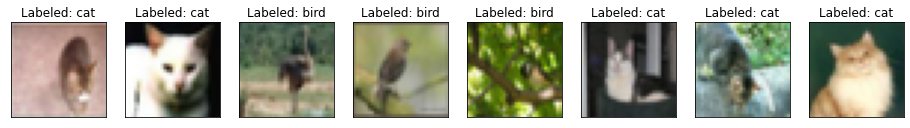

<Figure size 432x288 with 0 Axes>

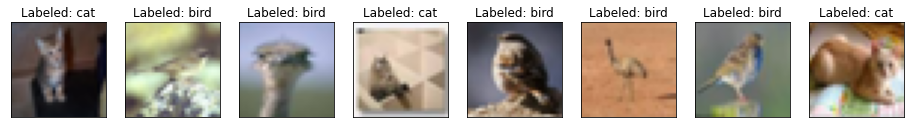

<Figure size 432x288 with 0 Axes>

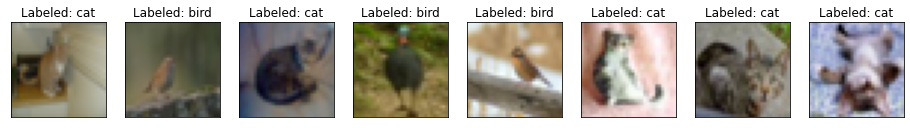

<Figure size 432x288 with 0 Axes>

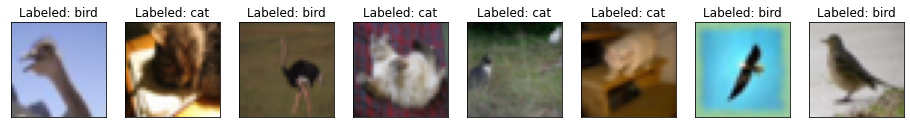

<Figure size 432x288 with 0 Axes>

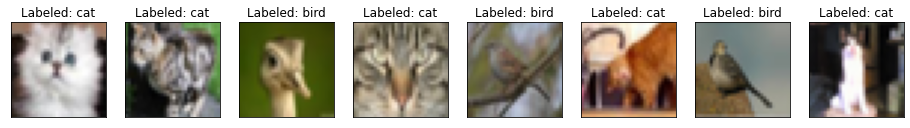

<Figure size 432x288 with 0 Axes>

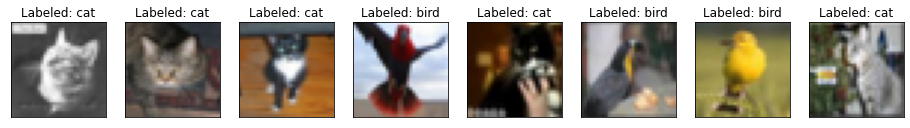

<Figure size 432x288 with 0 Axes>

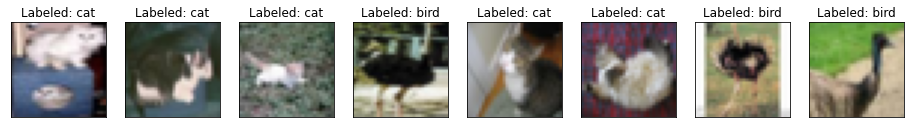

<Figure size 432x288 with 0 Axes>

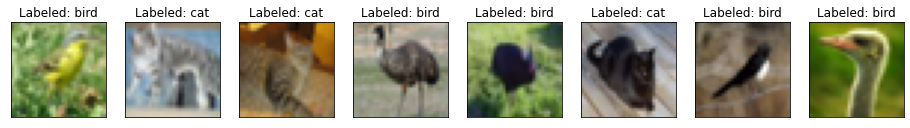

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        n_filts_fc1 = int(((((input_resolution[0]+7-4)/2)-4)/2)**2)*16
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

Batch 0, Loss: 0.01972360908985138
Batch 1, Loss: -1.2285020351409912
Batch 2, Loss: -0.30241408944129944
Batch 3, Loss: -1.2492130994796753
Batch 4, Loss: -0.4150504469871521
Batch 5, Loss: -0.01368808001279831
Batch 6, Loss: 0.04274071753025055
Batch 7, Loss: -0.8939796090126038
Batch 8, Loss: 0.14517846703529358
Batch 9, Loss: -0.8185364007949829
Batch 10, Loss: 0.37970978021621704
Batch 11, Loss: 0.0026954561471939087
Batch 12, Loss: -1.0505460500717163
Batch 13, Loss: -1.108674168586731
Batch 14, Loss: -0.06491811573505402
Batch 15, Loss: -1.180801510810852
Batch 16, Loss: -0.8175411820411682
Batch 17, Loss: -0.11839589476585388
Batch 18, Loss: -1.338057279586792
Batch 19, Loss: -0.5586321949958801
Batch 20, Loss: -0.939860463142395
Batch 21, Loss: -1.2088510990142822
Batch 22, Loss: -0.723938524723053
Batch 23, Loss: -0.9730594158172607
Batch 24, Loss: -0.7945455312728882
Batch 25, Loss: -0.3098262846469879
Batch 26, Loss: -0.037853240966796875
Batch 27, Loss: -0.6205658912658691

Batch 34, Loss: -1.0307433605194092
Batch 35, Loss: -0.6331127882003784
Batch 36, Loss: 0.14068681001663208
Batch 37, Loss: -0.2884492576122284
Batch 38, Loss: -0.38022854924201965
Batch 39, Loss: 0.733703076839447
Batch 40, Loss: -0.8414992094039917
Batch 41, Loss: -1.1829150915145874
Batch 42, Loss: -0.9005827903747559
Batch 43, Loss: -0.6948224306106567
Batch 44, Loss: 0.37948498129844666
Batch 45, Loss: -0.23343481123447418
Batch 46, Loss: -0.3246264159679413
Batch 47, Loss: -0.5361354947090149
Batch 48, Loss: -1.0834500789642334
Batch 49, Loss: -0.6631550788879395
Batch 50, Loss: -0.439706951379776
Batch 51, Loss: -1.0812441110610962
Batch 52, Loss: -0.32150983810424805
Batch 53, Loss: -0.8294036388397217
Batch 54, Loss: -0.9598346948623657
Batch 55, Loss: -0.2753395736217499
Batch 56, Loss: -0.41500845551490784
Batch 57, Loss: 0.061085060238838196
Batch 58, Loss: -0.5360385775566101
Batch 59, Loss: 0.20283916592597961
Batch 60, Loss: -0.3110252916812897
Batch 61, Loss: -1.0136220

Batch 3, Loss: 0.37431788444519043
Batch 4, Loss: -0.7046505212783813
Batch 5, Loss: -0.40324121713638306
Batch 6, Loss: 0.10504607856273651
Batch 7, Loss: -1.115392804145813
Batch 8, Loss: -0.21291927993297577
Batch 9, Loss: -0.27189308404922485
Batch 10, Loss: 0.33502212166786194
Batch 11, Loss: -0.1697119176387787
Batch 12, Loss: -0.3917936086654663
Batch 13, Loss: -0.41410163044929504
Batch 14, Loss: -0.7624812722206116
Batch 15, Loss: -0.18114566802978516
Batch 16, Loss: -1.5049540996551514
Batch 17, Loss: -0.6178610324859619
Batch 18, Loss: 0.4361434578895569
Batch 19, Loss: -0.4284827411174774
Batch 20, Loss: -0.595939576625824
Batch 21, Loss: -0.8832154870033264
Batch 22, Loss: -0.9235326051712036
Batch 23, Loss: -0.8051000237464905
Batch 24, Loss: -0.7408955693244934
Batch 25, Loss: -0.9627258777618408
Batch 26, Loss: -0.8446136713027954
Batch 27, Loss: 0.2808593809604645
Batch 28, Loss: -1.0364751815795898
Batch 29, Loss: -0.4590942859649658
Batch 30, Loss: 0.0307309553027153

Batch 37, Loss: -0.558424174785614
Batch 38, Loss: 0.08633231371641159
Batch 39, Loss: -0.6173200607299805
Batch 40, Loss: -0.8124697208404541
Batch 41, Loss: -0.9202944040298462
Batch 42, Loss: -0.8520314693450928
Batch 43, Loss: 0.017052918672561646
Batch 44, Loss: -0.5932554006576538
Batch 45, Loss: -0.9262946844100952
Batch 46, Loss: -0.09580722451210022
Batch 47, Loss: -0.3867833614349365
Batch 48, Loss: -0.8426469564437866
Batch 49, Loss: -0.8525186777114868
Batch 50, Loss: -0.6320352554321289
Batch 51, Loss: 0.1757630556821823
Batch 52, Loss: -0.17432689666748047
Batch 53, Loss: -0.08553047478199005
Batch 54, Loss: -0.8196479082107544
Batch 55, Loss: 0.020167484879493713
Batch 56, Loss: 0.19983963668346405
Batch 57, Loss: -0.4510449171066284
Batch 58, Loss: -0.850261926651001
Batch 59, Loss: -0.12080260366201401
Batch 60, Loss: -1.0022084712982178
Batch 61, Loss: -1.4377702474594116
Batch 62, Loss: -0.6866393685340881
Batch 63, Loss: -0.9494748115539551
Training [37%]	Loss: -0.5

Batch 6, Loss: -0.5619222521781921
Batch 7, Loss: -0.5099018216133118
Batch 8, Loss: -0.6924759149551392
Batch 9, Loss: -1.3840326070785522
Batch 10, Loss: -1.7441847324371338
Batch 11, Loss: 0.27292773127555847
Batch 12, Loss: -0.7915747165679932
Batch 13, Loss: -0.1912151277065277
Batch 14, Loss: -0.5095685124397278
Batch 15, Loss: -0.014724738895893097
Batch 16, Loss: -0.37243109941482544
Batch 17, Loss: -0.9900349378585815
Batch 18, Loss: -0.03013334423303604
Batch 19, Loss: -1.2320737838745117
Batch 20, Loss: -1.0419894456863403
Batch 21, Loss: 0.1540854275226593
Batch 22, Loss: -0.6316784620285034
Batch 23, Loss: -0.9577032327651978
Batch 24, Loss: -0.21923325955867767
Batch 25, Loss: -0.6538996696472168
Batch 26, Loss: -1.08861243724823
Batch 27, Loss: -0.41537246108055115
Batch 28, Loss: -0.8303419947624207
Batch 29, Loss: 0.06962792575359344
Batch 30, Loss: -0.651653528213501
Batch 31, Loss: -1.048572301864624
Batch 32, Loss: -0.7210357785224915
Batch 33, Loss: -0.114882238209

Batch 40, Loss: -1.482924461364746
Batch 41, Loss: -1.2814065217971802
Batch 42, Loss: -0.7125125527381897
Batch 43, Loss: -0.742052435874939
Batch 44, Loss: -0.45508331060409546
Batch 45, Loss: -0.3147330582141876
Batch 46, Loss: -0.8757299184799194
Batch 47, Loss: -0.9396501779556274
Batch 48, Loss: -1.0575793981552124
Batch 49, Loss: -0.8574899435043335
Batch 50, Loss: -1.438946008682251
Batch 51, Loss: 0.14415106177330017
Batch 52, Loss: -0.4567854106426239
Batch 53, Loss: -0.9581007957458496
Batch 54, Loss: -0.5942780375480652
Batch 55, Loss: -0.28310197591781616
Batch 56, Loss: -1.1597520112991333
Batch 57, Loss: -0.8304829001426697
Batch 58, Loss: -0.2274843454360962
Batch 59, Loss: -1.1535894870758057
Batch 60, Loss: -0.625927209854126
Batch 61, Loss: 0.3055199086666107
Batch 62, Loss: -0.1741054207086563
Batch 63, Loss: 0.13123482465744019
Training [60%]	Loss: -0.5878
Batch 0, Loss: -1.4050756692886353
Batch 1, Loss: -1.09050714969635
Batch 2, Loss: -0.6152087450027466
Batch 3

Batch 10, Loss: 0.09675391763448715
Batch 11, Loss: -0.8513790369033813
Batch 12, Loss: -0.705220103263855
Batch 13, Loss: -0.811149001121521
Batch 14, Loss: -0.7820214033126831
Batch 15, Loss: -0.547228217124939
Batch 16, Loss: -0.8480305075645447
Batch 17, Loss: -0.7716166973114014
Batch 18, Loss: -1.0741634368896484
Batch 19, Loss: -0.33545026183128357
Batch 20, Loss: -0.6961494088172913
Batch 21, Loss: -0.9371414184570312
Batch 22, Loss: 0.03205235302448273
Batch 23, Loss: -1.0035593509674072
Batch 24, Loss: -0.14373695850372314
Batch 25, Loss: -1.0669208765029907
Batch 26, Loss: -0.37918907403945923
Batch 27, Loss: -0.9797634482383728
Batch 28, Loss: -0.37645989656448364
Batch 29, Loss: -1.1982649564743042
Batch 30, Loss: -0.24084240198135376
Batch 31, Loss: -0.4402284324169159
Batch 32, Loss: -0.4496374726295471
Batch 33, Loss: -0.0018531978130340576
Batch 34, Loss: -0.8171349763870239
Batch 35, Loss: -0.3954649567604065
Batch 36, Loss: -0.5354358553886414
Batch 37, Loss: -0.1776

Batch 44, Loss: -0.5020902156829834
Batch 45, Loss: -1.3068997859954834
Batch 46, Loss: -1.0160925388336182
Batch 47, Loss: -0.34263619780540466
Batch 48, Loss: -0.7173271179199219
Batch 49, Loss: -1.6086077690124512
Batch 50, Loss: -0.38389351963996887
Batch 51, Loss: -0.9517794847488403
Batch 52, Loss: -1.061411738395691
Batch 53, Loss: -0.987769603729248
Batch 54, Loss: -0.807289719581604
Batch 55, Loss: -1.1169673204421997
Batch 56, Loss: -0.0999826192855835
Batch 57, Loss: -0.5972471833229065
Batch 58, Loss: -0.631056010723114
Batch 59, Loss: -1.2444887161254883
Batch 60, Loss: -0.4848158657550812
Batch 61, Loss: 0.07002493739128113
Batch 62, Loss: 0.01347462460398674
Batch 63, Loss: -1.740881085395813
Training [83%]	Loss: -0.5884
Batch 0, Loss: -0.8943690061569214
Batch 1, Loss: -0.5890651941299438
Batch 2, Loss: -1.4449396133422852
Batch 3, Loss: -0.0026792138814926147
Batch 4, Loss: -0.14078807830810547
Batch 5, Loss: -0.16811025142669678
Batch 6, Loss: -0.29359671473503113
Bat

Batch 13, Loss: -1.0965356826782227
Batch 14, Loss: -0.2512042224407196
Batch 15, Loss: -0.7002524137496948
Batch 16, Loss: -0.43078529834747314
Batch 17, Loss: -0.15867026150226593
Batch 18, Loss: -0.6595386266708374
Batch 19, Loss: -1.5581475496292114
Batch 20, Loss: -0.6837360858917236
Batch 21, Loss: -0.4775342643260956
Batch 22, Loss: -0.8584858179092407
Batch 23, Loss: -0.4227660894393921
Batch 24, Loss: -0.646718442440033
Batch 25, Loss: -0.7232943773269653
Batch 26, Loss: -0.790842592716217
Batch 27, Loss: -0.6896784901618958
Batch 28, Loss: -0.7759067416191101
Batch 29, Loss: -0.49190253019332886
Batch 30, Loss: -1.111124038696289
Batch 31, Loss: -0.17982102930545807
Batch 32, Loss: -0.13173827528953552
Batch 33, Loss: -0.8853726983070374
Batch 34, Loss: -0.6738362312316895
Batch 35, Loss: -0.19109252095222473
Batch 36, Loss: -1.3974641561508179
Batch 37, Loss: -0.7465077042579651
Batch 38, Loss: -0.6503200531005859
Batch 39, Loss: -0.017178744077682495
Batch 40, Loss: -0.6218

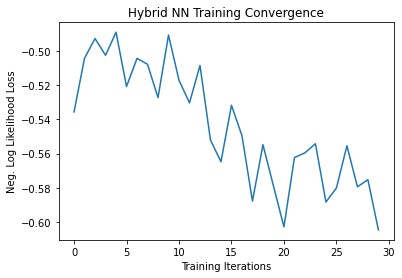

Training time: 0.0013513080193661153 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [8]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


Performance on test data:
	Loss: -0.5972
	Accuracy: 50.0%
Test time: 0.0023873019963502884 s


<Figure size 432x288 with 0 Axes>

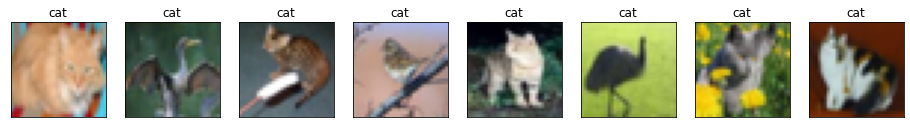

<Figure size 432x288 with 0 Axes>

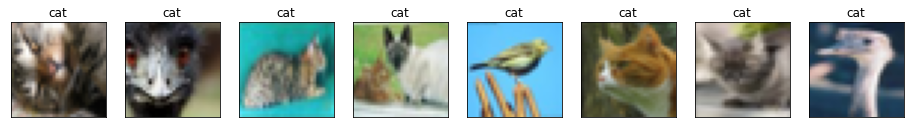

<Figure size 432x288 with 0 Axes>

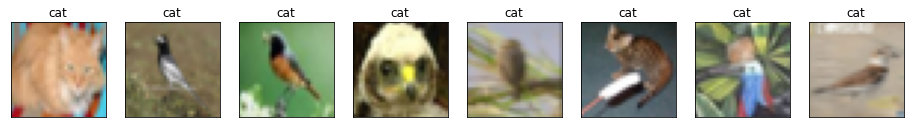

<Figure size 432x288 with 0 Axes>

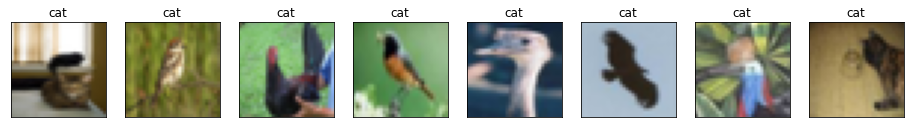

<Figure size 432x288 with 0 Axes>

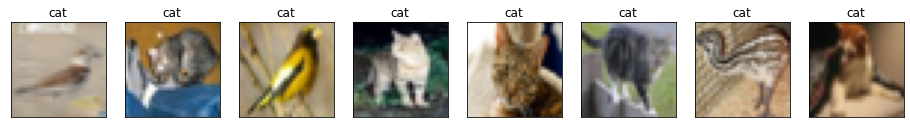

<Figure size 432x288 with 0 Axes>

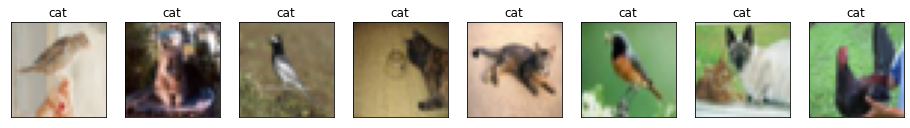

<Figure size 432x288 with 0 Axes>

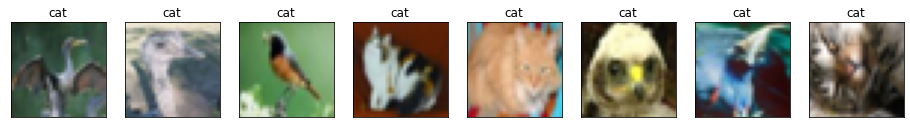

<Figure size 432x288 with 0 Axes>

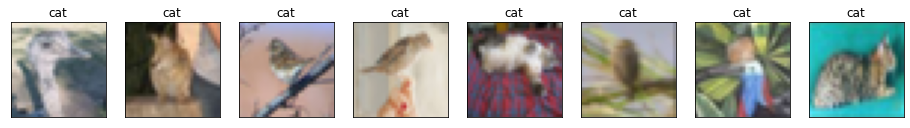

In [9]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 